# Task 3 Finetuning with pretrained pubmed bert on 20k pubmed Dataset

In [1]:
import io
import re
import os
import nlp
import random
import string
import shutil
import pathlib
import itertools
import tensorflow_text

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

In [3]:
from sklearn import metrics
from official.nlp import optimization
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## Path configuration

In [4]:
working_path            = pathlib.Path().resolve()
path_object             = pathlib.Path(working_path)
parent_path             = path_object.parent
data_path               = os.path.join(parent_path, "01-Data/PubMed_20k_RCT_numbers_replaced_with_at_sign/")
model_path_parent       = os.path.join(parent_path, "03-Models/")
tensorboard_path_parent = os.path.join(parent_path, "04-Logs/03-Task3")

## Parameter Settings

In [5]:
dataset_name    = 'pubmed20k'
model_name      = 'pubmed_bert_finetuning'

#If you want to reduce the training set to acclerate the training->giving worse results
train_samples   = -1    #Reduce if want to work with smaller dataset
val_samples     = -1   #Reduce train_validation time to long
test_samples    = -1    #Adjust to reduce evaluation time


batch_size      = 64     #Reduce if memory usage to high
# steps_per_epoch = 1000    #Influences total trainings  steps with it the learning rate and optimizer
# epochs          = 100


In [6]:
# Read in pubmed data files 
def get_lines(filename):
    with open(filename, "r") as f:    
        return f.readlines()
    
    
# Plotting Confusion Matrix   
def plot_confusion_matrix(
    y_true,
    y_pred,
    classes,
    normalize=False,
    title="Confusion matrix",
    cmap=plt.cm.Blues,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)
    plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    
    
# Confusion Matrix Callback for Keras
def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    Y_test = np.concatenate([y for x, y in test_ds], axis=0)
    test_pred = model.predict(test_ds)
    test_pred = np.argmax(test_pred, axis=-1)
    classes = [*class_to_index]
    cm = metrics.confusion_matrix(Y_test, test_pred)
    normalize = True
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    figure = plt.figure(figsize=(9, 6))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix "+model_name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

    buf = io.BytesIO()
    plt.savefig(buf, format='png')

    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)

    # Log the confusion matrix as an image summary.
    file_writer = tf.summary.create_file_writer(tensorboard_path)
    with file_writer.as_default():
        tf.summary.image("Confusion Matrix", image, step=epoch)

# Preparing data
def prepare_text(filename):
    """Returns a pandas dataframe.
    
    Reads filenames, its contents, seperates labels and text, lower text, remove_punctuation
    tokenize,remove stopwords,stemming and lemmatize

    Args:
        filename

    Returns:
        pd.dataframe

    """
    input_lines = get_lines(filename)
    abstract_lines = "" 
    abstract_dict_list = [] 

    for line in input_lines:
        if line.startswith("###"): # check if new ID
            abstract_lines = "" #simple reset
        elif line.isspace(): # if new line?
            splitted_abstract_lines = abstract_lines.splitlines() # split abstract into separate lines
            for split_line in splitted_abstract_lines:
                abstract_dict = {} # create dict for easy df transfer
                split = split_line.split("\t") # split label from text with \t
                abstract_dict["text"]=split[1].lower()
                abstract_dict["label"] = split[0] # get label
                abstract_dict_list.append(abstract_dict)
        else: 
            abstract_lines += line
    df = pd.DataFrame(abstract_dict_list)
    return df
from keras import backend as K

def recall_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_scores(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
#Get tokenizer i.e preprocesser model and encoder model trained on pubmed data
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/google/experts/bert/pubmed/2'
bert_preprocess_model   = hub.KerasLayer(tfhub_handle_preprocess)
bert_model              = hub.KerasLayer(tfhub_handle_encoder)

In [8]:
# Dataframes (can take a while 1-2 mins for me)
df_train = prepare_text(data_path + "train.txt")
df_val   = prepare_text(data_path + "dev.txt")
df_test  = prepare_text(data_path + "test.txt")

In [9]:
# Get text as list
train_sentences = df_train["text"].tolist()
val_sentences   = df_val["text"].tolist()
test_sentences  = df_test["text"].tolist()

In [10]:
#Helper dicts with relationships and inverse relationships
classes            = set(df_train.label.tolist())
class_to_index     = dict((c,i) for i, c in enumerate(classes))
index_to_class     = dict((v,k) for k, v in class_to_index.items())
names_to_ids       = lambda labels: np.array([class_to_index.get(x) for x in labels])
single_digit_train = names_to_ids(df_train.label.tolist())
single_digit_val   = names_to_ids(df_val.label.tolist())
single_digit_test  = names_to_ids(df_test.label.tolist())

In [11]:
# Transform to tf dataset for simplifing usage
train_ds = (
    tf.data.Dataset.from_tensor_slices((train_sentences[0:train_samples], single_digit_train[0:train_samples]))
    .shuffle(batch_size * 100)
    .batch(batch_size)
    .map(lambda text,label: (bert_preprocess_model(text),label),num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((val_sentences[0:val_samples], single_digit_val[0:val_samples]))
    .batch(batch_size)
    .map(lambda text,label: (bert_preprocess_model(text),label),num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((test_sentences[0:test_samples], single_digit_test[0:test_samples]))
    .batch(batch_size)
    .map(lambda text,label: (bert_preprocess_model(text),label),num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [12]:
# Define finetuning Model, setting trainable = True
tf.keras.backend.clear_session()
def PubmedBert(encoder_input):
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')   #Pubmed Pretrained bertencoder
    outputs = encoder(encoder_input)
    
    #Attach classifier, which is also trained
    net = outputs['pooled_output']                                                        #Encoder Outputs to be classified
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(5, activation="softmax", name='classifier')(net)          #Use 5 Classes and softmax
    return tf.keras.Model(encoder_input, net)

In [13]:
#Define paths
tensorboard_path = os.path.join(tensorboard_path_parent,model_name)
file_writer      = tf.summary.create_file_writer(tensorboard_path)

# Define Callbacks
early          = EarlyStopping(monitor="val_accuracy",mode="max", patience=2, verbose=1,restore_best_weights=True)
tbc            = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path,profile_batch = '120,160')
cm_callback    = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
callbacks_list = [
                  early,
                  tbc,
                  cm_callback,
]

#delete folder if already existing
try:
    shutil.rmtree(tensorboard_path)
except:
    pass

## Get Model i.e. Classifier

In [14]:
text_input    = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
encoder_input = bert_preprocess_model(text_input)
model       = PubmedBert(encoder_input)

In [15]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

In [16]:
#For AdamW we need to know some things...
epochs             = 10
steps_per_epoch    = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps    = steps_per_epoch * epochs
num_warmup_steps   = int(0.1*num_train_steps)

init_lr    = 1e-6
optimizer  = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

METRICS = [
      tf.metrics.SparseCategoricalAccuracy(name="accuracy"),
]

In [17]:
model.compile(optimizer = optimizer,
             loss       = loss,
             metrics    = METRICS)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 BERT_encoder (KerasLayer)      {'default': (None,   109482241   ['input_1[0][0]',                
                                768),                             'input_2[0][0]',            

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = model.fit(x                = train_ds,
                    validation_data  = val_ds,
                    epochs           = epochs,
                    steps_per_epoch  = steps_per_epoch,
                    validation_steps = 100,
                    callbacks        = callbacks_list,
                   )

Training model with https://tfhub.dev/google/experts/bert/pubmed/2
Epoch 1/10
2814/2814 [==============================] - 1256s 434ms/step - loss: 0.8474 - accuracy: 0.6703 - val_loss: 0.3713 - val_accuracy: 0.8727
Epoch 2/10
2814/2814 [==============================] - 1239s 440ms/step - loss: 0.3924 - accuracy: 0.8606 - val_loss: 0.3285 - val_accuracy: 0.8819
Epoch 3/10
2814/2814 [==============================] - 1234s 438ms/step - loss: 0.3664 - accuracy: 0.8679 - val_loss: 0.3156 - val_accuracy: 0.8850
Epoch 4/10
2814/2814 [==============================] - 1275s 453ms/step - loss: 0.3519 - accuracy: 0.8732 - val_loss: 0.3101 - val_accuracy: 0.8867
Epoch 5/10
2814/2814 [==============================] - 1213s 431ms/step - loss: 0.3439 - accuracy: 0.8757 - val_loss: 0.3058 - val_accuracy: 0.8867
Epoch 6/10
2814/2814 [==============================] - 1204s 428ms/step - loss: 0.3386 - accuracy: 0.8767 - val_loss: 0.3032 - val_accuracy: 0.8886
Epoch 7/10
2814/2814 [=================

## Model Evaluation

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


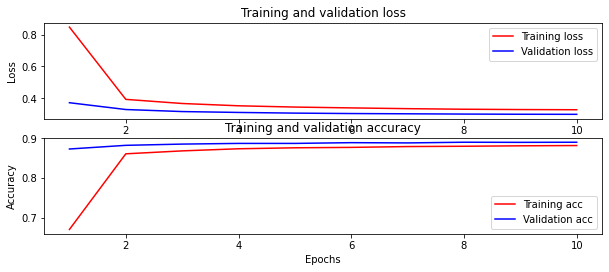

In [19]:
#Basic Plots
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']


epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(3, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [25]:
#Save Model
saved_model_path = os.path.join(model_path_parent,dataset_name+"_"+model_name)
model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: C:\Users\guthr\Coding\ML4HC\02-Natural_Language_Processing\03-Models/pubmed20k_pubmed_bert_finetuning\assets


INFO:tensorflow:Assets written to: C:\Users\guthr\Coding\ML4HC\02-Natural_Language_Processing\03-Models/pubmed20k_pubmed_bert_finetuning\assets


In [26]:
#Reload Model
reloaded_model = tf.keras.models.load_model(saved_model_path,compile=False)

In [27]:
#Get predictions for ACC, F1-Score and CM
pred_test = reloaded_model.predict(test_ds)
pred_test = tf.argmax(pred_test, axis=1)
Y_test    = np.concatenate([y for x, y in test_ds], axis=0)

Test F1 score : 0.8770
Test ACC score : 0.8781
Normalized confusion matrix
[[8.33698031e-01 8.53391685e-02 1.00656455e-02 1.53172867e-03
  6.93654267e-02]
 [3.32544013e-02 9.15680016e-01 4.86976217e-02 2.05909606e-04
  2.16205086e-03]
 [3.43538446e-03 2.52601799e-02 9.56249368e-01 4.95099525e-03
  1.01040719e-02]
 [1.54307758e-02 3.85769396e-03 3.77196742e-02 5.72653236e-01
  3.70338620e-01]
 [4.99861917e-02 3.86633527e-03 3.31400166e-02 9.63822149e-02
  8.16625242e-01]]


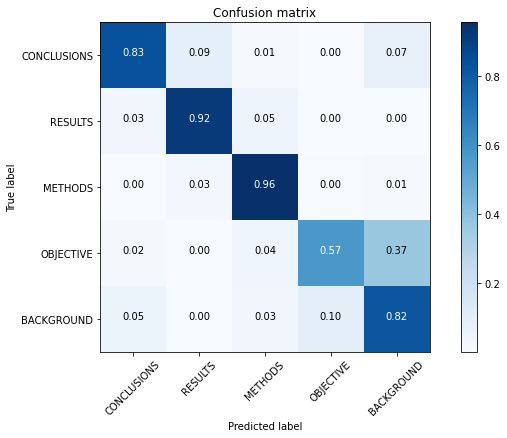

In [28]:
f1   = f1_score(Y_test, pred_test, average="weighted")
acc  = accuracy_score(Y_test, pred_test)

print("Test F1 score : {:.4f}".format(np.mean(f1)))
print("Test ACC score : {:.4f}".format(np.mean(acc)))

plot_confusion_matrix(
    Y_test,
    pred_test,
    [*class_to_index],
    normalize=True,
    title="Confusion matrix",
    cmap=plt.cm.Blues)